# Result import

In [1]:
import pickle

class DatasetManager:
    def __init__(self):
        # Initialize the dataset dictionary
        self.datasets = {}

    def add_dataset(self, name, dataset):
        """
        Adds a dataset to the manager.
        
        Args:
            name (str): The name of the dataset.
            dataset (dict): The dataset to be added.
        """
        self.datasets[name] = dataset

    def save_datasets(self, filename):
        """
        Save the datasets to a file.
        
        Args:
            filename (str): The name of the file where datasets will be saved.
        """
        try:
            with open(filename, 'wb') as f:
                pickle.dump(self.datasets, f)
            print(f"Datasets successfully saved to {filename}.")
        except Exception as e:
            print(f"Error saving datasets: {e}")

    def load_datasets(self, filename):
        """
        Load datasets from a file.
        
        Args:
            filename (str): The name of the file from which datasets will be loaded.
        """
        try:
            with open(filename, 'rb') as f:
                self.datasets = pickle.load(f)
            print(f"Datasets successfully loaded from {filename}.")
        except Exception as e:
            print(f"Error loading datasets: {e}")

    def get_datasets(self):
        """
        Returns the current datasets.
        """
        return self.datasets

In [26]:
from datetime import datetime

# Create an instance of DatasetManager
manager = DatasetManager()

manager.load_datasets(f"./assets/datasets/{datetime.today().strftime('%Y-%m-%d')}_dataset.pkl")

# To get the datasets after loading:
loaded_datasets = manager.get_datasets()

quantumsim_noise_gates_results = loaded_datasets["QuantumSim Noise Gates"]
quantumsim_noisy_gates_results = loaded_datasets["QuantumSim Noisy Gates"]
qiskit_simple_noise_model_results = loaded_datasets["Qiskit Simple Noise Model"]
qiskit_noisy_gates_results = loaded_datasets["Qiskit Noisy Gates"]
qiskit_ibm_kyiv_results = loaded_datasets["Qiskit IBM Kyiv"]

Datasets successfully loaded from ./assets/datasets/11012025_dataset.pkl.
Datasets successfully loaded from ./assets/datasets/11012025_dataset_IQFT_addon.pkl.


# Setup

In [4]:
ITERATIONS = 10
SHOTS_PER_ITERATION = 1000

# Plots

In [5]:
from matplotlib import pyplot as plt, colors
from ipywidgets import Checkbox, VBox, interact, widgets, interactive_output, HBox, HTML
from IPython.display import display
from math import sqrt
import numpy as np

## Average Z values of the chained X gates

In [6]:
def plot_chained_x_gates_z_interactive(datasets):
    """
    Plots the averages of each entry in the Z-measurement values across iterations
    for multiple datasets with interactive on/off using ipywidgets.
    """

    def plot(**kwargs):
        plt.figure(figsize=(8, 6))

        for i, name in enumerate(datasets):
            if kwargs[f"checkbox_{i}"]:
                z_values = [iteration["z"] for iteration in datasets[name]["CHAINED_X_GATES"]]
                transposed_z_values = list(zip(*z_values))
                z_averages = [sum(entry) / len(entry) for entry in transposed_z_values]
                x_values = list(range(len(z_averages)))

                plt.plot(x_values, z_averages, label=name)

        plt.xlabel("Entry Index")
        plt.ylabel("Average Z Measurement")
        plt.title("Averages of Z Measurement Across Chained X Gates")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Dynamically create checkboxes for datasets
    kwargs = {f"checkbox_{i}": Checkbox(value=True, description=name) for i, name in enumerate(datasets)}

    # Use interact with dynamically generated widgets
    interact(plot, **kwargs)

# Example usage
# Ensure datasets are correctly populated
datasets = {
    "QuantumSim - Noise gates": quantumsim_noise_gates_results,
    "QuantumSim - Noisy gates": quantumsim_noisy_gates_results
}

plot_chained_x_gates_z_interactive(datasets)

interactive(children=(Checkbox(value=True, description='QuantumSim - Noise gates'), Checkbox(value=True, descr…

## Dynamic plots for visualizing different test case results

In [7]:
def get_list_of_average_counts(circuit_results, use = "reg"):
    """
    Calculates the average counts for all variants in a list of dictionaries 
    containing measurement results.

    Args:
        circuit_results: A list of dictionaries, where each dictionary 
                         has a key "result" containing a list of strings 
                         representing measurement outcomes (e.g., "|0000000>", "|1111111>").

    Returns:
        A dictionary containing the average counts for all observed variants.
    """
    num_experiments = len(circuit_results)

    if num_experiments == 0:
        return
    
    # Aggregate total counts for all variants
    total_counts = {}
    for result_dict in circuit_results:
        if use == "inv":
            for result in result_dict["result_inv"]:
                total_counts[result] = total_counts.get(result, 0) + 1
        elif use == "reg":
            for result in result_dict["result"]:
                total_counts[result] = total_counts.get(result, 0) + 1
        else:
            for result in result_dict["mean"]:
                total_counts[result] = total_counts.get(result, 0) + 1
    
    # Calculate average counts for each variant
    average_counts = {variant: round(count / num_experiments) for variant, count in total_counts.items()}
    
    # Adjust to ensure the sum of all averages is 1000
    total_average = sum(average_counts.values())
    difference = 1000 - total_average
    
    # Distribute the difference across the variants to balance
    variants = list(average_counts.keys())
    for i in range(abs(difference)):
        key = variants[i % len(variants)]
        average_counts[key] += 1 if difference > 0 else -1
    
    return average_counts

def get_total_counts(circuit_results, use="reg"):
    """
    Counts the total occurrences of each outcome across all iterations and shots.

    Args:
        circuit_results (list): A list of dictionaries, where each dictionary 
                                contains measurement results under a specified key.
        use (str): Specifies which key to use for counting results. Options are
                   "reg", "inv", or "mean". Defaults to "reg".

    Returns:
        dict: A dictionary where keys are outcomes (e.g., "|0000000>", "|1111111>") 
              and values are the total counts across all iterations and shots.
    """
    # Initialize a dictionary to store total counts
    total_counts = {}
    
    # Iterate through the results and aggregate counts
    for result_dict in circuit_results:
        if use == "inv":
            for result in result_dict.get("result_inv", []):
                total_counts[result] = total_counts.get(result, 0) + 1
        elif use == "reg":
            for result in result_dict.get("result", []):
                total_counts[result] = total_counts.get(result, 0) + 1
        else:
            for result in result_dict.get("mean", []):
                total_counts[result] = total_counts.get(result, 0) + 1

    return total_counts

def plot_histogram(selected_datasets, all_datasets):
    """
    Plots a histogram based on the selected datasets.
    
    Args:
        selected_datasets: A list of dataset names to include in the plot.
    """
    if not selected_datasets:
        # Handle case where no datasets are selected
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'No data selected', fontsize=18, ha='center', va='center')
        plt.axis('off')
    else:
        # Filter out invalid or None datasets
        valid_datasets = [name for name in selected_datasets if name in all_datasets and all_datasets[name] is not None]

        if not valid_datasets:
            # Handle case where no valid datasets remain
            plt.figure(figsize=(10, 6))
            plt.text(0.5, 0.5, 'No valid datasets selected', fontsize=18, ha='center', va='center')
            plt.axis('off')
            plt.show()
            return

        # Dynamically find all unique labels across valid datasets
        all_labels = set()
        for dataset_name in valid_datasets:
            all_labels.update(all_datasets[dataset_name].keys())
        all_labels = sorted(all_labels)  # Sort labels for consistent order

        if not all_labels:
            # Handle case where valid datasets are empty or have no valid labels
            plt.figure(figsize=(10, 6))
            plt.text(0.5, 0.5, 'No valid data in selected datasets', fontsize=18, ha='center', va='center')
            plt.axis('off')
            plt.show()
            return

        plt.figure(figsize=(10, 6))
        total_width = 0.8  # Total width allocated for each label group
        cmap = colors.ListedColormap(plt.cm.Greys(np.linspace(0.4, 1.0, len(valid_datasets))))

        # Plotting each dataset
        bar_positions = {label: [] for label in all_labels}  # Track bar positions for each label
        for label_idx, label in enumerate(all_labels):
            # Filter datasets that have counts for this label
            datasets_with_label = [
                (dataset_idx, all_datasets[dataset_name].get(label, 0))
                for dataset_idx, dataset_name in enumerate(valid_datasets)
                if all_datasets[dataset_name].get(label, 0) > 0
            ]

            num_bars = len(datasets_with_label)  # Number of bars in this group
            if num_bars > 0:
                individual_width = total_width / num_bars  # Width of each bar

                for i, (dataset_idx, count) in enumerate(datasets_with_label):
                    total = sum(all_datasets[valid_datasets[dataset_idx]].values())
                    count = (count / total) * 100  # Convert to percentage

                    bar_position = label_idx - total_width / 2 + (i + 0.5) * individual_width
                    bar_positions[label].append(bar_position)
                    plt.bar(
                        bar_position,
                        count,
                        width=individual_width * 0.9,  # Slightly reduce width for spacing
                        label=valid_datasets[dataset_idx] if label_idx == 0 else "",  # Avoid duplicate legends
                        color=cmap(dataset_idx),
                    )

        # Adjust x-axis labels to be centered under each group of bars
        label_positions = [
            np.mean(bar_positions[label]) if bar_positions[label] else 0
            for label in all_labels
        ]
        plt.xticks(label_positions, all_labels)

        plt.title(f'Classical State Output Percentage over {ITERATIONS*SHOTS_PER_ITERATION} Shots')
        plt.ylabel('Percentage')
        plt.legend(title='Datasets', loc="upper center")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        # plt.tight_layout()
        SMALL_SIZE = 8
        MEDIUM_SIZE = 10
        BIGGER_SIZE = 15

        plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.show()

# Tooltip message displayed below the multi-select
tooltip_message = HTML(
    value="<b>Tip:</b> Hold Shift or Ctrl to select multiple datasets."
)

### Create datasets consisting of the averages

In [27]:
total_counts_dataset = {
    "QuantumSim Noise Gates": {
        "CHAINED_X_GATES": get_total_counts(quantumsim_noise_gates_results["CHAINED_X_GATES"]),
        "GHZ_ALGORITHM": {
            2: get_total_counts(quantumsim_noise_gates_results["GHZ_ALGORITHM_2"]),
            3: get_total_counts(quantumsim_noise_gates_results["GHZ_ALGORITHM_3"]),
            4: get_total_counts(quantumsim_noise_gates_results["GHZ_ALGORITHM_4"]),
            5: get_total_counts(quantumsim_noise_gates_results["GHZ_ALGORITHM_5"]),
        },
    },
    "QuantumSim Noisy Gates": {
        "CHAINED_X_GATES": get_total_counts(quantumsim_noisy_gates_results["CHAINED_X_GATES"]),
        "GHZ_ALGORITHM": {
            2: get_total_counts(quantumsim_noisy_gates_results["GHZ_ALGORITHM_2"]),
            3: get_total_counts(quantumsim_noisy_gates_results["GHZ_ALGORITHM_3"]),
            4: get_total_counts(quantumsim_noisy_gates_results["GHZ_ALGORITHM_4"]),
            5: get_total_counts(quantumsim_noisy_gates_results["GHZ_ALGORITHM_5"]),
        },
        "IQFT_ALGORITHM": {
            2: get_total_counts(quantumsim_noisy_gates_results["IQFT_ALGORITHM_2"]),
            3: get_total_counts(quantumsim_noisy_gates_results["IQFT_ALGORITHM_3"]),
        },
    },
    "Qiskit Simple Noise Model": {
        "CHAINED_X_GATES": get_total_counts(qiskit_simple_noise_model_results["CHAINED_X_GATES"]),
        "GHZ_ALGORITHM": {
            2: get_total_counts(qiskit_simple_noise_model_results["GHZ_ALGORITHM_2"]),
            3: get_total_counts(qiskit_simple_noise_model_results["GHZ_ALGORITHM_3"]),
            4: get_total_counts(qiskit_simple_noise_model_results["GHZ_ALGORITHM_4"]),
            5: get_total_counts(qiskit_simple_noise_model_results["GHZ_ALGORITHM_5"]),
        },
        "IQFT_ALGORITHM": {
            2: get_total_counts(qiskit_simple_noise_model_results["IQFT_ALGORITHM_2"]),
            3: get_total_counts(qiskit_simple_noise_model_results["IQFT_ALGORITHM_3"]),
        },
    },
    "Qiskit Noisy Gates": {
        "CHAINED_X_GATES": get_total_counts(qiskit_noisy_gates_results["CHAINED_X_GATES"]),
        "GHZ_ALGORITHM": {
            2: get_total_counts(qiskit_noisy_gates_results["GHZ_ALGORITHM_2"], "reg"),
            3: get_total_counts(qiskit_noisy_gates_results["GHZ_ALGORITHM_3"], "reg"),
            4: get_total_counts(qiskit_noisy_gates_results["GHZ_ALGORITHM_4"], "reg"),
            5: get_total_counts(qiskit_noisy_gates_results["GHZ_ALGORITHM_5"], "reg"),
        },
        "IQFT_ALGORITHM": {
            2: get_total_counts(qiskit_noisy_gates_results["IQFT_ALGORITHM_2"]),
            3: get_total_counts(qiskit_noisy_gates_results["IQFT_ALGORITHM_3"]),
        },
    },
    "Qiskit IBM Kyiv": {
        "CHAINED_X_GATES": get_total_counts(qiskit_ibm_kyiv_results["CHAINED_X_GATES"]),
        "GHZ_ALGORITHM": {
            2: get_total_counts(qiskit_ibm_kyiv_results["GHZ_ALGORITHM_2"]),
            3: get_total_counts(qiskit_ibm_kyiv_results["GHZ_ALGORITHM_3"]),
            4: get_total_counts(qiskit_ibm_kyiv_results["GHZ_ALGORITHM_4"]),
            5: get_total_counts(qiskit_ibm_kyiv_results["GHZ_ALGORITHM_5"]),
        },
        "IQFT_ALGORITHM": {
            2: get_total_counts(qiskit_ibm_kyiv_results["IQFT_ALGORITHM_2"]),
            3: get_total_counts(qiskit_ibm_kyiv_results["IQFT_ALGORITHM_3"]),
        },
    },
}

### 120 chained x gates

In [9]:
datasets_chained_x_test = {
    "QuantumSim Noise Gates": total_counts_dataset["QuantumSim Noise Gates"]["CHAINED_X_GATES"],
    "QuantumSim Noisy Gates": total_counts_dataset["QuantumSim Noisy Gates"]["CHAINED_X_GATES"],
    "Qiskit Simple Noise Model": total_counts_dataset["Qiskit Simple Noise Model"]["CHAINED_X_GATES"],
    "Qiskit Noisy Gates": total_counts_dataset["Qiskit Noisy Gates"]["CHAINED_X_GATES"],
    "Qiskit IBM Kyiv": total_counts_dataset["Qiskit IBM Kyiv"]["CHAINED_X_GATES"],
}

# Value widget of datasets
datasets_value_widget_chained_x_test = widgets.ValueWidget()
datasets_value_widget_chained_x_test.value = datasets_chained_x_test

# Multi-select widget
dataset_selector_chained_x_test = widgets.SelectMultiple(
    options=list(datasets_chained_x_test.keys()),
    value=["QuantumSim Noisy Gates"],  # Default selection
    description='Select datasets:',
    style={'description_width': 'initial'}
)

# Interactive output
interactive_histogram_chained_x_test = interactive_output(
    plot_histogram,
    {'selected_datasets': dataset_selector_chained_x_test, 'all_datasets': datasets_value_widget_chained_x_test}
)

# Layout
ui_chained_x_test = VBox([
    dataset_selector_chained_x_test,
    tooltip_message
])
display(ui_chained_x_test, interactive_histogram_chained_x_test)

Output()

### GHZ Algorithm test

In [10]:
datasets_ghz_algorithm_test = {
    "QuantumSim Noise Gates": total_counts_dataset["QuantumSim Noise Gates"]["GHZ_ALGORITHM"][3],
    "QuantumSim Noisy Gates": total_counts_dataset["QuantumSim Noisy Gates"]["GHZ_ALGORITHM"][3],
    "Qiskit Default Noise Model": total_counts_dataset["Qiskit Simple Noise Model"]["GHZ_ALGORITHM"][3],
    "Qiskit Noisy Gates": total_counts_dataset["Qiskit Noisy Gates"]["GHZ_ALGORITHM"][3],
    "IBM Kyiv": total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][3],
}

# Value widget of datasets
datasets_value_widget_ghz_algorithm_test = widgets.ValueWidget()
datasets_value_widget_ghz_algorithm_test.value = datasets_ghz_algorithm_test

# Multi-select widget
dataset_selector_ghz_algorithm_test = widgets.SelectMultiple(
    options=list(datasets_ghz_algorithm_test.keys()),
    value=["QuantumSim Noisy Gates"],  # Default selection
    description='Select datasets:',
    style={'description_width': 'initial'}
)

# Interactive output
interactive_histogram_ghz_algorithm_test = interactive_output(
    plot_histogram,
    {
        'selected_datasets': dataset_selector_ghz_algorithm_test, 
        'all_datasets': datasets_value_widget_ghz_algorithm_test,
    }
)

# Layout
ui_ghz_algorithm_test = VBox([
    dataset_selector_ghz_algorithm_test,
    tooltip_message,
])
display(ui_ghz_algorithm_test, interactive_histogram_ghz_algorithm_test)

Output()

#### Hellinger distances

In [11]:
def calculate_hellinger_distance(data1, data2):
    """
    Calculates the Hellinger distance between two datasets.

    Args:
        data1: Dictionary of counts for dataset 1.
        data2: Dictionary of counts for dataset 2.

    Returns:
        The Hellinger distance between the two datasets.
    """
    # Normalize counts to probabilities
    total1 = sum(data1.values())
    total2 = sum(data2.values())
    prob1 = {key: count / total1 for key, count in data1.items()}
    prob2 = {key: count / total2 for key, count in data2.items()}
    
    # Align labels
    all_labels = set(prob1.keys()).union(prob2.keys())
    prob1 = {label: prob1.get(label, 0) for label in all_labels}
    prob2 = {label: prob2.get(label, 0) for label in all_labels}
    
    # Calculate Hellinger distance
    hellinger_distance = sqrt(0.5 * sum((sqrt(prob1[label]) - sqrt(prob2[label]))**2 for label in all_labels))
    
    return hellinger_distance

In [12]:
hellinger_distances = {
    "IBM Kyiv vs Qiskit Default Noise Model": {
        2: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][2], total_counts_dataset["Qiskit Simple Noise Model"]["GHZ_ALGORITHM"][2]),
        3: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][3], total_counts_dataset["Qiskit Simple Noise Model"]["GHZ_ALGORITHM"][3]),
        4: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][4], total_counts_dataset["Qiskit Simple Noise Model"]["GHZ_ALGORITHM"][4]),
        5: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][5], total_counts_dataset["Qiskit Simple Noise Model"]["GHZ_ALGORITHM"][5]),
    },
    "IBM Kyiv vs QuantumSim Noisy Gates": {
        2: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][2], total_counts_dataset["QuantumSim Noisy Gates"]["GHZ_ALGORITHM"][2]),
        3: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][3], total_counts_dataset["QuantumSim Noisy Gates"]["GHZ_ALGORITHM"][3]),
        4: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][4], total_counts_dataset["QuantumSim Noisy Gates"]["GHZ_ALGORITHM"][4]),
        5: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][5], total_counts_dataset["QuantumSim Noisy Gates"]["GHZ_ALGORITHM"][5]),
    },
    # "IBM Kyiv vs Qiskit Noisy Gates": {
    #     2: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][2], total_counts_dataset["Qiskit Noisy Gates"]["GHZ_ALGORITHM"][2]),
    #     3: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][3], total_counts_dataset["Qiskit Noisy Gates"]["GHZ_ALGORITHM"][3]),
    #     4: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][4], total_counts_dataset["Qiskit Noisy Gates"]["GHZ_ALGORITHM"][4]),
    #     5: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["GHZ_ALGORITHM"][5], total_counts_dataset["Qiskit Noisy Gates"]["GHZ_ALGORITHM"][5]),
    # },
}


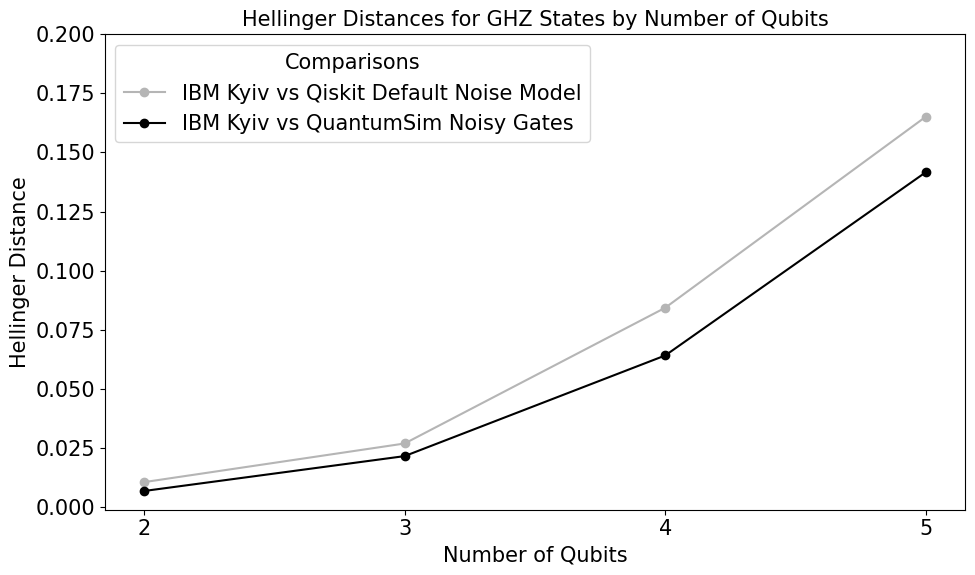

In [13]:
# Define color map
cmap = colors.ListedColormap(plt.cm.Greys(np.linspace(0.4, 1.0, len(hellinger_distances))))

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through the dictionary and plot each entry
for idx, (label, data) in enumerate(hellinger_distances.items()):
    qubits = list(data.keys())  # Extract qubits (x-axis)
    distances = list(data.values())  # Extract Hellinger distances (y-axis)
    
    plt.plot(
        qubits,
        distances,
        marker='o',
        linestyle='-',  # You can customize this
        color=cmap(idx),  # Use the colormap for unique colors
        label=label  # Use the dictionary key as the label
    )

# Add titles and labels
plt.title("Hellinger Distances for GHZ States by Number of Qubits")
plt.xlabel("Number of Qubits")
plt.ylabel("Hellinger Distance")
plt.xticks(range(2,6))  # Set the x-axis ticks explicitly

# Set the y-axis start, step size, and end
y_start = 0.0  # Starting value for y-axis
y_end = 0.2  # Maximum value for y-axis
y_step = 0.025  # Step size
y_ticks = np.arange(y_start, y_end + y_step, y_step)  # Generate ticks dynamically
plt.yticks(y_ticks)  # Apply the y-axis ticks

# Add a legend
plt.legend(title="Comparisons", loc='upper left')

# Adjust layout to avoid clipping
plt.tight_layout()

# Display the plot
plt.show()

### IQFT algorithm

In [28]:
datasets_iqft_algorithm_test = {
    "QuantumSim Noisy Gates": total_counts_dataset["QuantumSim Noisy Gates"]["IQFT_ALGORITHM"][3],
    "Qiskit Default Noise Model": total_counts_dataset["Qiskit Simple Noise Model"]["IQFT_ALGORITHM"][3],
    "Qiskit Noisy Gates": total_counts_dataset["Qiskit Noisy Gates"]["IQFT_ALGORITHM"][3],
    "IBM Kyiv": total_counts_dataset["Qiskit IBM Kyiv"]["IQFT_ALGORITHM"][3],
}

# Value widget of datasets
datasets_value_widget_iqft_algorithm_test = widgets.ValueWidget()
datasets_value_widget_iqft_algorithm_test.value = datasets_iqft_algorithm_test

# Multi-select widget
dataset_selector_iqft_algorithm_test = widgets.SelectMultiple(
    options=list(datasets_iqft_algorithm_test.keys()),
    value=["QuantumSim Noisy Gates"],  # Default selection
    description='Select datasets:',
    style={'description_width': 'initial'}
)

# Interactive output
interactive_histogram_iqft_algorithm_test = interactive_output(
    plot_histogram,
    {
        'selected_datasets': dataset_selector_iqft_algorithm_test, 
        'all_datasets': datasets_value_widget_iqft_algorithm_test,
    }
)

# Layout
ui_iqft_algorithm_test = VBox([
    dataset_selector_iqft_algorithm_test,
    tooltip_message,
])
display(ui_iqft_algorithm_test, interactive_histogram_iqft_algorithm_test)

Output()

#### Hellinger distances

In [29]:
hellinger_distances = {
    "IBM Kyiv vs Qiskit Default Noise Model": {
        2: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["IQFT_ALGORITHM"][2], total_counts_dataset["Qiskit Simple Noise Model"]["IQFT_ALGORITHM"][2]),
        3: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["IQFT_ALGORITHM"][3], total_counts_dataset["Qiskit Simple Noise Model"]["IQFT_ALGORITHM"][3]),
    },
    "IBM Kyiv vs QuantumSim Noisy Gates": {
        2: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["IQFT_ALGORITHM"][2], total_counts_dataset["QuantumSim Noisy Gates"]["IQFT_ALGORITHM"][2]),
        3: calculate_hellinger_distance(total_counts_dataset["Qiskit IBM Kyiv"]["IQFT_ALGORITHM"][3], total_counts_dataset["QuantumSim Noisy Gates"]["IQFT_ALGORITHM"][3]),
    },
}

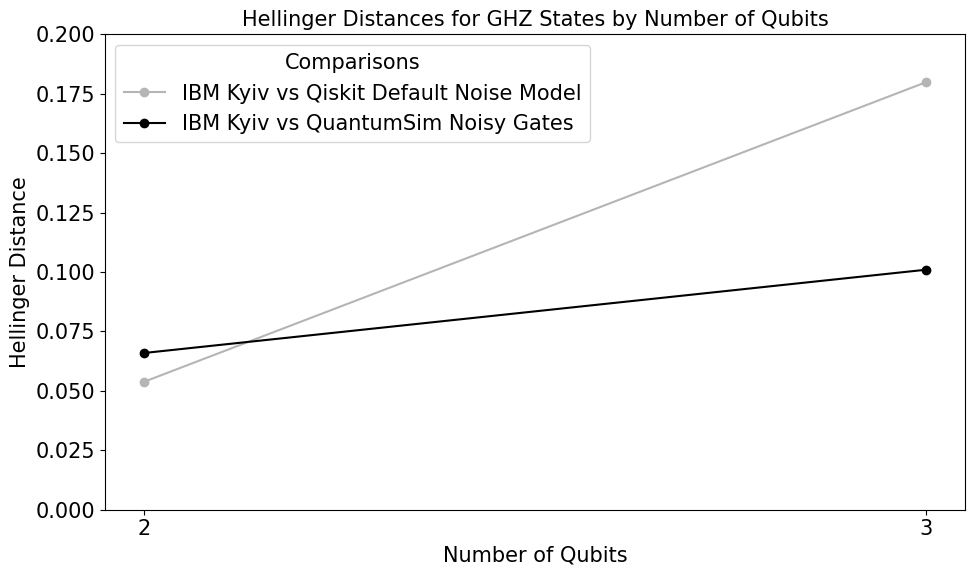

{2: 0.053817318688407695, 3: 0.17984212915282866}
{2: 0.06593600370555244, 3: 0.10096481526531995}


In [35]:
# Define color map
cmap = colors.ListedColormap(plt.cm.Greys(np.linspace(0.4, 1.0, len(hellinger_distances))))

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through the dictionary and plot each entry
for idx, (label, data) in enumerate(hellinger_distances.items()):
    qubits = list(data.keys())  # Extract qubits (x-axis)
    distances = list(data.values())  # Extract Hellinger distances (y-axis)
    
    plt.plot(
        qubits,
        distances,
        marker='o',
        linestyle='-',  # You can customize this
        color=cmap(idx),  # Use the colormap for unique colors
        label=label  # Use the dictionary key as the label
    )

# Add titles and labels
plt.title("Hellinger Distances for GHZ States by Number of Qubits")
plt.xlabel("Number of Qubits")
plt.ylabel("Hellinger Distance")
plt.xticks(range(2,4))  # Set the x-axis ticks explicitly

# Set the y-axis start, step size, and end
y_start = 0.0  # Starting value for y-axis
y_end = 0.2  # Maximum value for y-axis
y_step = 0.025  # Step size
y_ticks = np.arange(y_start, y_end + y_step, y_step)  # Generate ticks dynamically
plt.yticks(y_ticks)  # Apply the y-axis ticks

# Add a legend
plt.legend(title="Comparisons", loc='upper left')

# Adjust layout to avoid clipping
plt.tight_layout()

# Display the plot
plt.show()